# Unsupervised Spectral Unmixing with Autoencoders

By Joshua C. Agar, Shuyu Qin

* There are many times where you want to extract imporant features from high-dimensional data
* In essence, the goal is to compress data to some lower latent space where you can extract information

![](https://prateekvjoshi.files.wordpress.com/2014/06/3-swissroll-unfolded.png)

# Autoencoder
* **Encoder** - Neural network that deconstructs the data into the most important statistical components
* **Embedding Layer(s)** - One or many layers were information is extracted
* **Decoder** - Neural network that translates the latent space to original dimensionality. 

## Mathamatical Objective
* Minimize the reconstruction loss based on some metric. 
  * Mean squared errror

  Good at avoiding influence of anomolies
  * Mean absolute error

  Good at capturing details within spectra

## Optimizers
* Standard optimizers like ADAM tend to be suffiecent
* Can use more complex optimizers 2nd order, adhessian to optimize small models. 

## Practical Objective
* Create an autoencoder that has performant reconstruction
* Create a low-dimensional and interpretable latent space
  * Reduce the dimensionality
  * Impose non-negativity contraints
  * Impose regularization
  * Impose sparsity
  * Impose constraints on the shape of the latent distribution
  * Impose soft-constraints that favor disentanglement
* Create a latent trajectory that is suitable for generation 

In [ ]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split

In [ ]:
# Loads dog image
image = io.imread('/content/drive/MyDrive/Tutorials/MyTutorials/CNMS Deep Learning/nala.jpg')

# Crops dog image
image = image[200:1900:20, 100:1500:20]/255

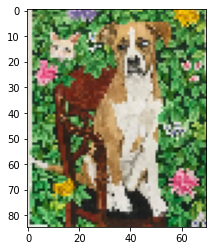

In [ ]:
plt.imshow(image)

Lets look at what the spectra looks like

In [ ]:
cmap = plt.cm.viridis((5)) 
cmap

(0.273809, 0.031497, 0.358853, 1.0)

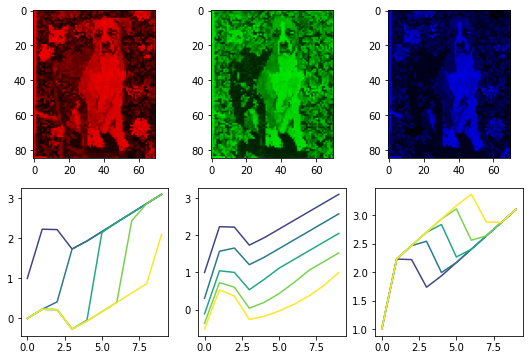

In [ ]:
fig, ax = layout_fig(6, mod=3)

ax = ax.ravel()

cmap = plt.cm.viridis 

for i, ax in enumerate(ax):
  if i<3:
    img = np.zeros(image.shape)
    img[:,:,i] = image[:,:,i]
    ax.imshow(img)
  else:
    values = np.zeros((5,3))
    values[:,i-3] = np.linspace(0,1,5)
    y_data = generate_data(values, length=10)
    for j in range(y_data.shape[0]):
      color = cmap((j + 1) / y_data.shape[0])
      ax.plot(y_data[j], c=color)

In [ ]:
def non_linear_fn(t, x, y, z):
  # returns a function from variables
  return tf.nn.tanh(20*(t - 2*(x-.5)))+ tf.nn.selu((t-2*(y-0.5))) + tf.nn.sigmoid(-20*(t-(z-0.5)))

In [ ]:
def generate_data(values, function=non_linear_fn, length=25, range_=[-1, 1]):
    """
    Function to generate data from values

    :param values: values to function for generating spectra
    :type values: float
    :param function:  mathematical expression used to generate spectra
    :type function: function, optional
    :param length: spectral length
    :type length: int (optional)
    :param range_: x range for function
    :type range_:  list of float
    :return: generatered spectra
    :rtype: array of float
    """

    # build x vector
    x = np.linspace(range_[0], range_[1], length)

    data = np.zeros((values.shape[0], length))

    for i in range(values.shape[0]):
        data[i, :] = function(x, values[i, 0], values[i, 1], values[i, 2])

    return data

In [ ]:
dog_data = generate_data(image.reshape(-1,3),length=10)

X_train, X_test, _, _ = train_test_split(dog_data, dog_data, 
                                        test_size=0.2, random_state=42)

Let's Build a Simple Autoencoder

In [ ]:
latent_dim = 12 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(10, activation='linear'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.build(X_train.shape)

In [ ]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (4760, 12)                132       
_________________________________________________________________
sequential_1 (Sequential)    (4760, 10)                130       
Total params: 262
Trainable params: 262
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.fit(X_train, X_train,
                epochs=20,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/20
149/149 [==============================] - 0s 3ms/step - loss: 1.5741 - val_loss: 0.3301
Epoch 2/20
149/149 [==============================] - 0s 2ms/step - loss: 0.2107 - val_loss: 0.1445
Epoch 3/20
149/149 [==============================] - 0s 2ms/step - loss: 0.1228 - val_loss: 0.1040
Epoch 4/20
149/149 [==============================] - 0s 2ms/step - loss: 0.0932 - val_loss: 0.0831
Epoch 5/20
149/149 [==============================] - 0s 2ms/step - loss: 0.0750 - val_loss: 0.0683
Epoch 6/20
149/149 [==============================] - 0s 2ms/step - loss: 0.0611 - val_loss: 0.0559
Epoch 7/20
149/149 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0457
Epoch 8/20
149/149 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0372
Epoch 9/20
149/149 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0308
Epoch 10/20
149/149 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0259

In [ ]:
encoded_spectra = autoencoder.encoder(dog_data).numpy()
decoded_spectra = autoencoder.decoder(encoded_spectra).numpy()

In [ ]:
maps = encoded_spectra.reshape(image.shape[0], image.shape[1],-1)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def layout_fig(graph, mod=None):

    """
    function

    :param graph: number of axes to make
    :type graph: int
    :param mod: sets the number of figures per row
    :type mod: int (, optional)
    :return: fig:
                handel to figure being created
             axes:
                numpy array of axes that are created
    :rtype: fig:
                matplotlib figure
            axes:
                numpy array
    """

    # Sets the layout of graphs in matplotlib in a pretty way based on the number of plots
    if mod is None:
        # Selects the number of columns to have in the graph
        if graph < 3:
            mod = 2
        elif graph < 5:
            mod = 3
        elif graph < 10:
            mod = 4
        elif graph < 17:
            mod = 5
        elif graph < 26:
            mod = 6
        elif graph < 37:
            mod = 7

    # builds the figure based on the number of graphs and selected number of columns
    fig, axes = plt.subplots(graph // mod + (graph % mod > 0), mod,
                             figsize=(3 * mod, 3 * (graph // mod + (graph % mod > 0))))

    # deletes extra unneeded axes
    axes = axes.reshape(-1)
    for i in range(axes.shape[0]):
        if i + 1 > graph:
            fig.delaxes(axes[i])

    return (fig, axes)


def embedding_maps(data, image, colorbar_shown=True,
                   c_lim=None, mod=None,
                   title=None):

    """

    :param data: data need to be showed in image format
    :type data: array
    :param image: the output shape of the image
    :type image: array
    :param colorbar_shown: whether to show the color bar on the left of image
    :type colorbar_shown: boolean
    :param c_lim: Sets the scales of colorbar
    :type c_lim: list
    :param mod: set the number of image for each line
    :type mod: int
    :param title: set the title of figure
    :type title: string
    :return: handel to figure being created
    :rtype: matplotlib figure
    """
    fig, ax = layout_fig(data.shape[1], mod)

    for i, ax in enumerate(ax):
        if i < data.shape[1]:
            im = ax.imshow(data[:, i].reshape(image.shape[0], image.shape[1]))
            ax.set_xticklabels('')
            ax.set_yticklabels('')

            # adds the colorbar
            if colorbar_shown == True:
                divider = make_axes_locatable(ax)
                cax = divider.append_axes('right', size='10%', pad=0.05)
                cbar = plt.colorbar(im, cax=cax, format='%.1e')

                # Sets the scales
                if c_lim is not None:
                    im.set_clim(c_lim)

    if title is not None:
        # Adds title to the figure
        fig.suptitle(title, fontsize=16,
                     y=1, horizontalalignment='center')

    fig.tight_layout()

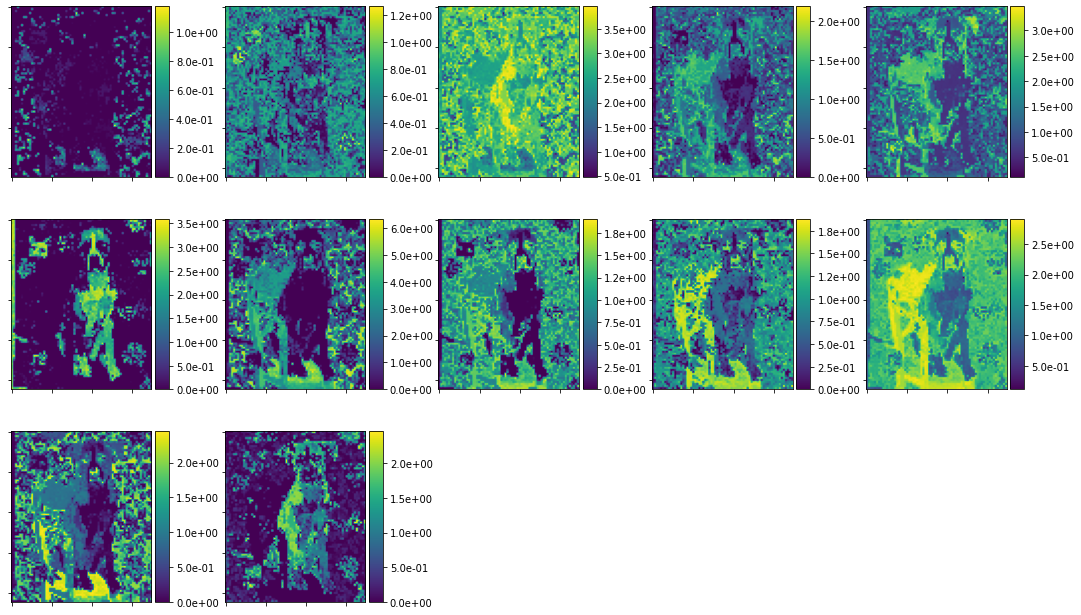

In [ ]:
embedding_maps(encoded_spectra, image)

While this captures the features of the image it is still too high-dimensional for detailed interpretation.


**In this case we know we have 3 endmembers set by RGB**

In [ ]:
tf.random.set_seed(42)

autoencoder = Autoencoder(3)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.build(X_train.shape)

In [ ]:
tf.random.set_seed(42)

autoencoder.fit(X_train, X_train,
                epochs=50,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/50
149/149 [==============================] - 0s 3ms/step - loss: 0.8591 - val_loss: 0.5388
Epoch 2/50
149/149 [==============================] - 0s 2ms/step - loss: 0.4494 - val_loss: 0.3701
Epoch 3/50
149/149 [==============================] - 0s 2ms/step - loss: 0.3242 - val_loss: 0.2749
Epoch 4/50
149/149 [==============================] - 0s 2ms/step - loss: 0.2433 - val_loss: 0.2102
Epoch 5/50
149/149 [==============================] - 0s 2ms/step - loss: 0.1906 - val_loss: 0.1704
Epoch 6/50
149/149 [==============================] - 0s 2ms/step - loss: 0.1602 - val_loss: 0.1491
Epoch 7/50
149/149 [==============================] - 0s 2ms/step - loss: 0.1440 - val_loss: 0.1376
Epoch 8/50
149/149 [==============================] - 0s 2ms/step - loss: 0.1352 - val_loss: 0.1313
Epoch 9/50
149/149 [==============================] - 0s 2ms/step - loss: 0.1301 - val_loss: 0.1273
Epoch 10/50
149/149 [==============================] - 0s 2ms/step - loss: 0.1267 - val_loss: 0.1246

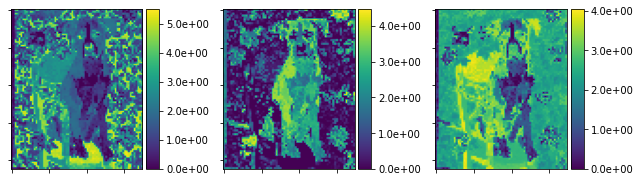

In [ ]:
encoded_spectra = autoencoder.encoder(dog_data).numpy()
decoded_spectra = autoencoder.decoder(encoded_spectra).numpy()
embedding_maps(encoded_spectra, image)

Now we would like to view what the spectra looks like as we generate across the latent space

In [ ]:
printing = {'PNG':True,
            'EPS':False, 
           'dpi': 300}

def imagemap(ax, data, colorbars=True, clim=None):
    """
    Plots an image map

    Parameters
    ----------
    axis : matplotlib, object
        axis which is plotted
    data  : numpy, float
        data to plot
    clim  : numpy, float, optional
        sets the climit for the image
    color_bar  : bool, optional
        selects to plot the colorbar bar for the image
    """
    if data.ndim == 1:
        data = data.reshape(np.sqrt(data.shape[0]).astype(
            int), np.sqrt(data.shape[0]).astype(int))

    cmap = plt.get_cmap('viridis')

    if clim is None:
        im = ax.imshow(data,  cmap=cmap)
    else:
        im = ax.imshow(data, clim=clim, cmap=cmap)

    ax.set_yticklabels('')
    ax.set_xticklabels('')

    if colorbars:
        # adds the colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='10%', pad=0.05)
        cbar = plt.colorbar(im, cax=cax, format='%.1e')

def find_nearest(array, value, averaging_number):
    """
    returns the indices nearest to a value in an image
    Parameters
    ----------
    array : float, array
        image to find the index closest to a value
    value : float
        value to find points near
    averaging_number : int
        number of points to find
    """
    idx = (np.abs(array-value)).argsort()[0:averaging_number]
    return idx

def make_folder(folder, **kwargs):
    """
    Function that makes new folders
    Parameters
    ----------'
    folder : string
        folder where to save
    Returns
    -------
    folder : string
        folder where to save
    """

    # Makes folder
    os.makedirs(folder, exist_ok=True)

    return (folder)

def generate_data(model,
                            embeddings,
                            image,
                            number,                            
                            average_number,
                            indx = None,
                            ranges = None,
                            x_values = None,
                            y_scale=[-2.2,4]):
    """
    plots the generator results

    Parameters
    ----------
    model : tensorflow object
        neural network model
    encode : float, array
        the input embedding (or output from encoder)
    voltage : float, array
        voltage array
    number : int
        number of divisions to plot
    averaging_number : int
        number of points to consider in the average
    ranges : float, array
        sets the ranges for the embeddings
    folder : string
        set the folder where to export the images
    plot_format  : dict
        sets the plot format for the images
    printing : dictionary
        contains information for printing
        'dpi': int
            resolution of exported image
        print_EPS : bool
            selects if export the EPS
        print_PNG : bool
            selects if print the PNG
    graph_layout : int, array (optional)
        sets the layout for the figure.

    """

    # sets the colormap
    cmap = plt.cm.viridis

    if indx is None:
      embedding_small = embeddings.squeeze()
    else:
      embedding_small = embeddings[:, indx].squeeze()
    
    
    # creates the figures and axes in a pretty way
    fig, ax = layout_fig(embedding_small.shape[1] * 2, mod = 3)

    # plots all of the embedding maps
    for i in range(embedding_small.shape[1]):

        im = imagemap(ax[i], embedding_small[:, i].reshape(image.shape[0], image.shape[1]))

    # loops around the number of example loops
    for i in range(number):

        # loops around the number of embeddings from the range file
        for j in range(embedding_small.shape[1]):

            if ranges is None:
              value = np.linspace(np.min(embedding_small[:, j]), 
                                  np.max(embedding_small[:, j]), number)
            else:
              # sets the linear spaced values
              value = np.linspace(0, ranges[j], number)

            idx = find_nearest(
                embedding_small[:, j], value[i], average_number)
            gen_value = np.mean(embeddings[idx], axis=0)
            gen_value[j] = value[i]

            # computes the generated results
            generated = model.predict(np.atleast_2d(gen_value)).squeeze()

            # plots and formats the graphs
            if x_values is None:
              ax[j + embedding_small.shape[1]
                ].plot(generated, color=cmap((i + 1) / number))
            else:
              ax[j + embedding_small.shape[1]
                ].plot(x_values, generated, color=cmap((i + 1) / number))

            ax[j + embedding_small.shape[1]].set_ylim(y_scale)
            ax[j + embedding_small.shape[1]].set_yticklabels('')
            plt.tight_layout(pad=1)

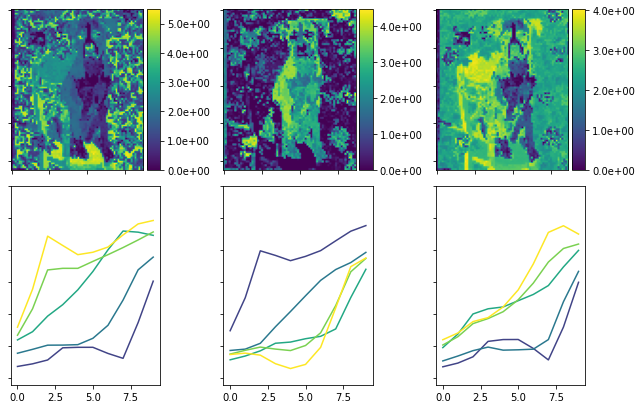

In [ ]:
generate_data(autoencoder.decoder, encoded_spectra, image, 5, 10)